# Automatic Speech Recognition with Transformer

Training a sequence-to-sequence Transformer for automatic speech recognition.

## Introduction

Automatic speech recognition (ASR) consists of transcribing audio speech segments into text.
ASR can be treated as a sequence-to-sequence problem, where the
audio can be represented as a sequence of feature vectors
and the text as a sequence of characters, words, or subword tokens.

**References:**

- [Attention is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [Very Deep Self-Attention Networks for End-to-End Speech Recognition](https://arxiv.org/pdf/1904.13377.pdf)
- [Speech Transformers](https://ieeexplore.ieee.org/document/8462506)
- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)

In [1]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Define the Transformer Input Layer

When processing past target tokens for the decoder, we compute the sum of
position embeddings and token embeddings.

When processing audio features, we apply convolutional layers to downsample
them (via convolution stides) and process local relationships.

In [4]:

class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        #tf.debugging.check_numerics(x, message='')
        x = self.conv1(x)
        #tf.debugging.check_numerics(x, message='')
        x = self.conv2(x)
        return self.conv3(x)


## Transformer Encoder Layer

In [29]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Transformer Decoder Layer

In [30]:

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


## Complete the Transformer model

Our model takes audio spectrograms as inputs and predicts a sequence of characters.
During training, we give the decoder the target character sequence shifted to the left
as input. During inference, the decoder uses its own past predictions to predict the
next token.

In [31]:

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        #tf.debugging.check_numerics(source, message='')
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}


    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


## Preprocess the dataset

We preprocess dataset to create dictionary with mapping of audio files to corresponding transcripts. Then, we create training and test dataset with this dictionary with train split of 99% and test split of 1%.

In [48]:
id_to_text = {}
csv_file = 'mapping.csv'

with open(csv_file, encoding="utf-8") as f:
    wavs = []
    f.readline()
    for line in f:
        id = line.strip().split(",")[0]
        text = line.strip().split(",")[4]
        id_to_text[id] = text

def get_data(csv_file, prefix_path, id_to_text, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = []
    with open(csv_file, encoding='utf-8') as f:
        f.readline()
        for line in f:
            id = line.strip().split(",")[0]
            audio_path = prefix_path + line.strip().split(",")[-1]
            if len(id_to_text[id]) < maxlen:
                data.append({"audio": audio_path, "text": id_to_text[id]})
    return data

In [49]:

class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab

prefix_path = ''
max_target_len = 310  # all transcripts in out data are < 310 characters
data = get_data(csv_file, prefix_path, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means)
    x = tf.math.divide_no_nan(x, stddevs)
    audio_len = tf.shape(x)[0]
    # padding to 2754 seconds
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


split = int(100000*0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=128)
val_ds = create_tf_dataset(test_data, bs=10)

vocab size 34


## Callbacks to display predictions

In [51]:

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


## Learning rate schedule

In [52]:

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


## Create & train the end-to-end model

In [54]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.0008,
    final_lr=0.00001,
    warmup_epochs=25,
    decay_epochs=75,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

EPOCHS = 100
checkpoint_filepath = 'checkpoints\\weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

model.fit(ds, validation_data=val_ds, epochs=1, validation_steps=len(val_ds)/10)
model.load_weights('checkpoints\\model_original_dataset\\weights.22-0.50.hdf5')
history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb, model_checkpoint_callback], epochs=EPOCHS, validation_steps=len(val_ds)/10)

774/774 [==============================] - 709s 908ms/step - loss: 1.1807 - val_loss: 1.0395
Epoch 1/100
774/774 [==============================] - 709s 915ms/step - loss: 0.8094 - val_loss: 0.7618
target:     <interestingly and you can see the>
prediction: <in that is is is is is is in this is is is is is is is is in the is is in the is is is>

target:     <can have a large distribution network>
prediction: <the car the conding the conding of the conting to the requal to the requal to the is>

target:     <with tens of thousands of hubs what this>
prediction: <it is a see this this this this this this this this this this this this a so the so the sign>

target:     <supply is equal to the total external>
prediction: <of the constant the so the contion of the contion of the contion the so in the contion>

target:     <associated with each link which is>
prediction: <of the posing the read the intery the read the so the reasing the reading the reading the re>

target:     <varying in a 

774/774 [==============================] - 694s 895ms/step - loss: 0.4536 - val_loss: 0.5569
Epoch 23/100
774/774 [==============================] - 690s 891ms/step - loss: 0.4877 - val_loss: 0.6005
Epoch 24/100
774/774 [==============================] - 695s 897ms/step - loss: 0.4784 - val_loss: 0.5744
Epoch 25/100
774/774 [==============================] - 708s 914ms/step - loss: 0.4723 - val_loss: 0.5728
Epoch 26/100
774/774 [==============================] - 710s 916ms/step - loss: 0.4630 - val_loss: 0.5538
target:     <interestingly and you can see the>
prediction: <impressing the sproblem of the sting b and if you see the practical let of the>

target:     <can have a large distribution network>
prediction: <have allowed>

target:     <with tens of thousands of hubs what this>
prediction: <the same this same this same this same this same this same this>

target:     <supply is equal to the total external>
prediction: <supplies equal to the problem equal>

target:     <associated 

774/774 [==============================] - 711s 918ms/step - loss: 0.4014 - val_loss: 0.4877
Epoch 48/100
774/774 [==============================] - 713s 920ms/step - loss: 0.3994 - val_loss: 0.4833
Epoch 49/100
774/774 [==============================] - 692s 894ms/step - loss: 0.3973 - val_loss: 0.4775
Epoch 50/100
774/774 [==============================] - 695s 897ms/step - loss: 0.3954 - val_loss: 0.4769
Epoch 51/100
774/774 [==============================] - 695s 897ms/step - loss: 0.3934 - val_loss: 0.4751
target:     <interestingly and you can see the>
prediction: <interesting b for this problem is the processing b for this problem>

target:     <can have a large distribution network>
prediction: <you have a large if you can of alrithm which is network this>

target:     <with tens of thousands of hubs what this>
prediction: <ten the hundred of always the totar lecturnal>

target:     <supply is equal to the total external>
prediction: <applies equal to to the proto lextend value

774/774 [==============================] - 709s 914ms/step - loss: 0.3498 - val_loss: 0.4198
Epoch 93/100
774/774 [==============================] - 703s 907ms/step - loss: 0.3495 - val_loss: 0.4181
Epoch 94/100
774/774 [==============================] - 702s 907ms/step - loss: 0.3492 - val_loss: 0.4158
Epoch 95/100
774/774 [==============================] - 696s 898ms/step - loss: 0.3490 - val_loss: 0.4139
Epoch 96/100
774/774 [==============================] - 697s 900ms/step - loss: 0.3489 - val_loss: 0.4125
target:     <interestingly and you can see the>
prediction: <interestingly and you can see the practical mater of this problem we and you can see the problem>

target:     <can have a large distribution network>
prediction: <we can have a large is which network than the of sument of of something of so what this>

target:     <with tens of thousands of hubs what this>
prediction: <it can of the same is alongest the of so what the same is alongest the observe tota external>

targe

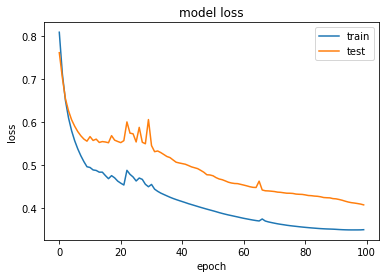

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()